In [1]:
from jupyter_imports import *
from copy import deepcopy

In [2]:
# run only once
from riskpnl.post_trade import batch_summarize_exec_logs # use 'prod' for remote after cache_tmp
start = datetime(2022,6,28,18)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','prod','tradeexecutor')#,'prod')
batch_summarize_exec_logs(dirname,start=start,add_history_context=False,rebuild=True)

moved 0 logs to unreadable
printed summaries to /tmp/prod/tradeexecutor


In [3]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_parameters','all_request','all_data']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),parse_dates=['log_time'],index_col=0) for file in files}

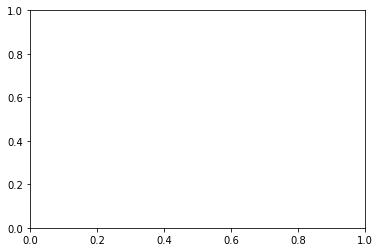

In [4]:
cmap = cm.get_cmap('Spectral')
fig, ax = plt.subplots(1)

## parameters for reference

In [5]:
all_parameters = original['all_parameters']
all_parameters = all_parameters[all_parameters['index']!='inception_time']
all_parameters['hash'] = all_parameters['log_time'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('log_time').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('log_time')['param_index'].to_dict()

In [6]:
indexed = deepcopy(original)
for df in indexed.values():
    df['param_index'] = df['log_time'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

### slippage, fees in bps. filled in USD

In [7]:
by_symbol = indexed['all_by_symbol']
by_symbol = by_symbol[by_symbol['log_time']>start.replace(tzinfo=timezone.utc)]
by_symbol['absFilled'] = by_symbol['filledUSD'].apply(np.abs)
by_symbol['total_bps'] = by_symbol['slippage_bps'] + by_symbol['fee']
by_symbol['fee_USD'] = by_symbol['fee']*by_symbol['absFilled']/10000 # in bps for by_symbol, in USD for by_clientorderid :(
by_symbol['slippage_USD'] = by_symbol['slippage_bps']*by_symbol['absFilled']/10000
by_symbol['total_USD'] = by_symbol['total_bps']*by_symbol['absFilled']/10000

In [8]:
df_symbol = by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',aggfunc=sum)
df_symbol[['fee_USD','slippage_USD','total_USD']] /= 10000*by_symbol[by_symbol['index']=='average'].pivot_table(index='log_time',values=['absFilled'],aggfunc=sum).values

<AxesSubplot:xlabel='log_time'>

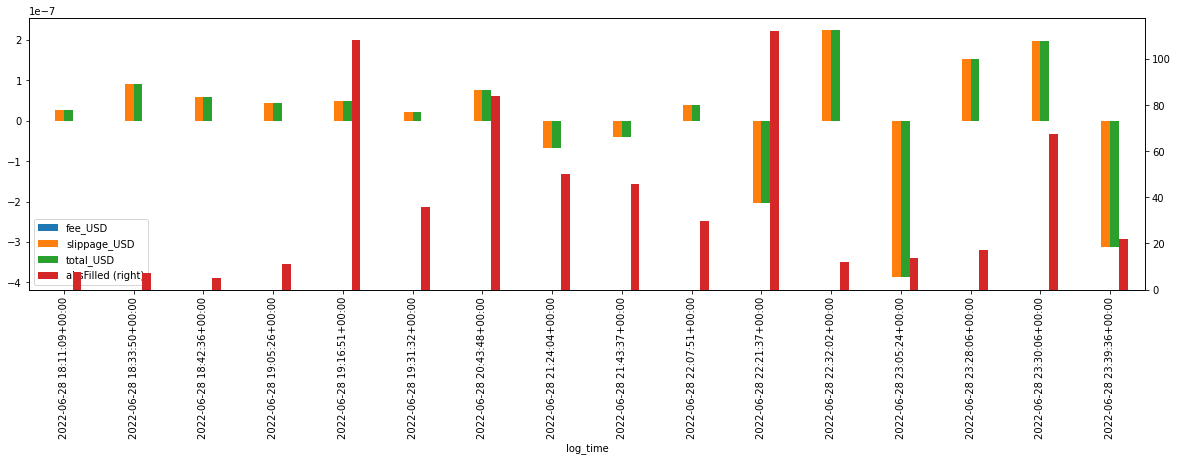

In [9]:
#ax.plot(df, c=df['param_index'], s=120, cmap=cmap, edgecolor='None',figsize=(20,10))
#plt.show()
df_symbol[['fee_USD','slippage_USD','total_USD','absFilled']].plot.bar(secondary_y='absFilled',figsize=(20,5))

### slippage distribution

        total_bps   fee
count   67.000000  67.0
mean    -0.092869   0.0
std     49.449244   0.0
min   -198.886237   0.0
25%    -12.711274   0.0
50%      3.866221   0.0
75%     14.977236   0.0
max    223.458139   0.0


<AxesSubplot:>

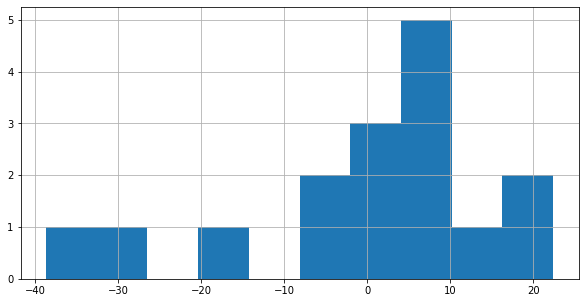

In [10]:
print(by_symbol[['total_bps','fee']].describe())
by_symbol.loc[by_symbol['index']=='average','total_bps'].hist(figsize=(10,5))

<AxesSubplot:xlabel='log_time'>

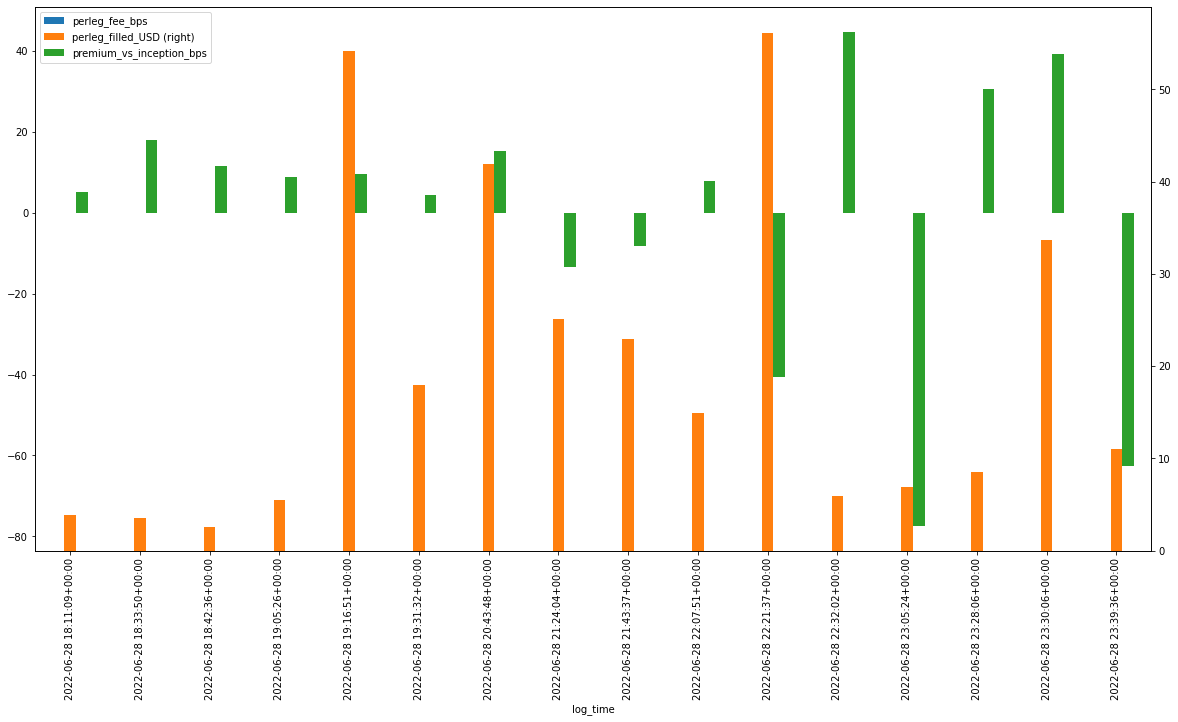

In [11]:
by_coin = indexed['all_by_coin']
trackrecord = by_coin[by_coin['index']=='average'].pivot_table(index='log_time',values=['perleg_fee_bps','perleg_filled_USD','premium_vs_inception_bps'],aggfunc=np.mean)
trackrecord.plot.bar(secondary_y='perleg_filled_USD',figsize=(20,10))

# latency

,tick_to_order_local
count,72.000000
mean,155.050581
std,159.172959
min,90.192139
25%,104.473022
50%,118.594116
75%,144.373840
max,1380.450195


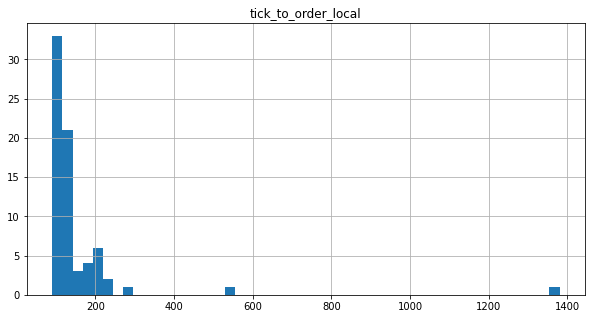

In [31]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['tick_to_order_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()

,round_trip
count,2875.000000
mean,163.172328
std,1393.685144
min,0.005371
25%,0.028320
50%,31.191895
75%,70.176025
max,26912.147949


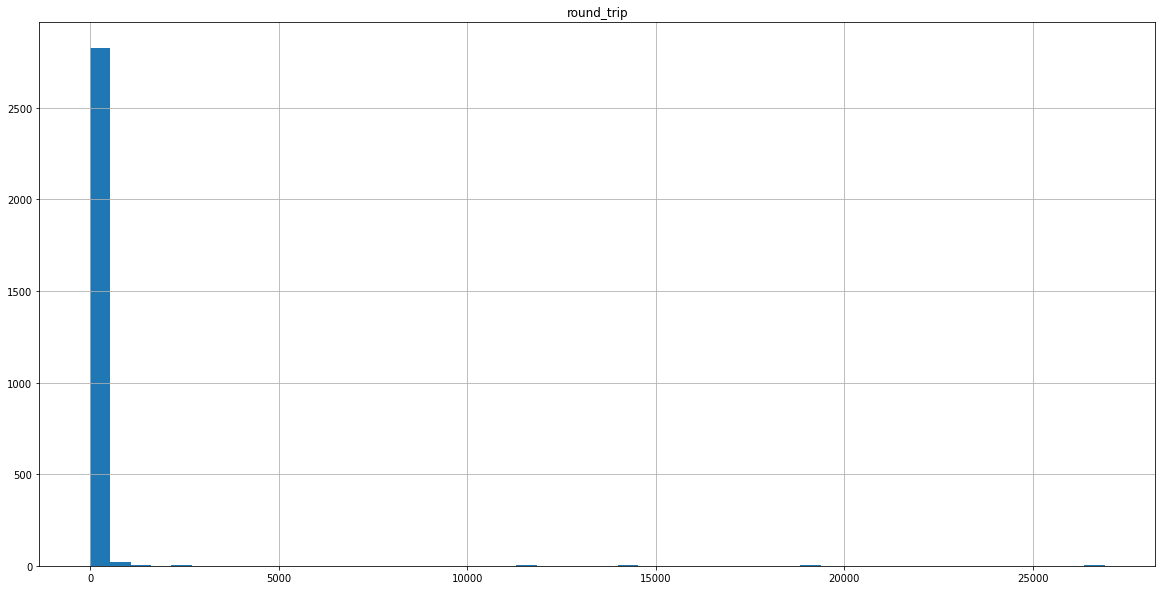

In [36]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_data']['timestamp']-indexed['all_data']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()